In [1]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import shap
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix,
                             average_precision_score, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from wandb.plot import scatter

/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['WANDB_NOTEBOOK_NAME'] = './diabetes-prediction.ipynb'
os.environ["WANDB_SILENT"] = "true"

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Load the dataset
df = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')

print(df['Diabetes_012'].value_counts())

# Remove 1 = prediabetes, and change 2 = diabetes to 1 = diabetes
df = df[df['Diabetes_012'] != 1.0].reset_index(drop=True)
df['Diabetes_012'] = df['Diabetes_012'].replace({2.0: 1.0})

df = df.rename(columns={'Diabetes_012': 'Diabetes_binary'})

# Display basic information about the dataset
print(df.info())
print(df.describe())

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249049 entries, 0 to 249048
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       249049 non-null  float64
 1   HighBP                249049 non-null  float64
 2   HighChol              249049 non-null  float64
 3   CholCheck             249049 non-null  float64
 4   BMI                   249049 non-null  float64
 5   Smoker                249049 non-null  float64
 6   Stroke                249049 non-null  float64
 7   HeartDiseaseorAttack  249049 non-null  float64
 8   PhysActivity          249049 non-null  float64
 9   Fruits                249049 non-null  float64
 10  Veggies               249049 non-null  float64
 11  HvyAlcoholConsump     249049 non-null  float64
 12  AnyHealthcare         249049 non-null  float64
 13  NoDocbcCost           2

### Dataset Description

Diabetes_binary (Target)

0 = no diabetes 1 = prediabetes or diabetes

HighBP

0 = no high BP 1 = high BP

HighChol

0 = no high cholesterol 1 = high cholesterol

CholCheck

0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years

BMI

Body Mass Index

Smoker

Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes

Stroke

(Ever told) you had a stroke. 0 = no 1 = yes

HeartDiseaseorAttack

coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

PhysActivity

physical activity in past 30 days - not including job 0 = no 1 = yes

Fruits

Consume Fruit 1 or more times per day 0 = no 1 = yes

Veggies

Consume Vegetables 1 or more times per day 0 = no 1 = yes

HvyAlcoholConsump

(adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes

AnyHealthcare

Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes

NoDocbcCost

Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes

GenHlth

Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

MentHlth

days of poor mental health scale 1-30 days (will be later mapped to 1 if 0 <= x <= 5 otherwise mapped to 2 in the code below)

PhysHlth

physical illness or injury days in past 30 days scale 1-30 (will be later mapped to 1 if 0 <= x <= 5 otherwise mapped to 2 in the code below)

DiffWalk

Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes

Sex

0 = female 1 = male

Age

13-level age category: 1 = 18-24 ... 9 = 60-64 ... 13 = 80 or older

Education

Education level scale 1-6: 1 = Never attended school or only kindergarten 2 = elementary etc.

Income

Income scale: scale 1-8 1 = less than $10,000 ... 5 = less than $35,000 ... 8 = $75,000 or more

The dataset contains 253,680 entries with 21 features. The target variable (Diabetes_012) contains 0 = no diabetes 1 = prediabetes 2 = diabetes. We have removed prediabetes (total 4631 instances) and changed 2 = diabetes to 1 = diabetes and renamed the variable to Diabetes_binary.

All features are either binary or integer types, with no missing values.

All features are stored as float64 data type, which may need to be adjusted for categorical variables.
There are no missing values in the dataset.

### A. Univariate Analysis

#### Distribution of Target Variable:

In [5]:
df['Diabetes_binary'].value_counts(normalize=True)

Diabetes_binary
0.0    0.858076
1.0    0.141924
Name: proportion, dtype: float64

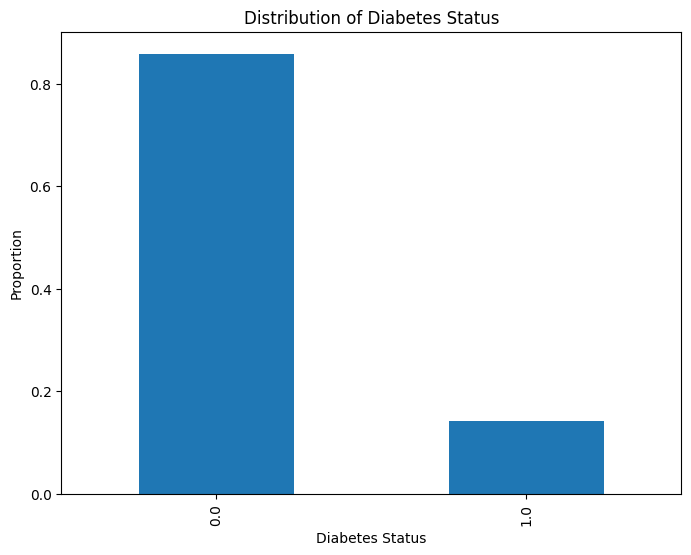

In [6]:
plt.figure(figsize=(8, 6))
df['Diabetes_binary'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Proportion')
plt.show()

The target variable 'Diabetes_binary' is imbalanced:

0 (No diabetes): 85.8%

1 (Diabetes): 14.2%

This imbalance will need to be addressed in our modeling approach.

#### Distribution of Numerical Features:

In [7]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Feature': df.columns,
    'Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Unique Values': df.nunique(),
    'Min': df.min(),
    'Max': df.max(),
    'Mean': df.mean(),
    'Median': df.median(),
    'Std Dev': df.std(),
    'Correlation with Diabetes': df.corr()['Diabetes_binary']
})

# Reorder columns
summary = summary[['Feature', 'Type', 'Non-Null Count', 'Null Count', 'Unique Values', 
                   'Min', 'Max', 'Mean', 'Median', 'Std Dev', 'Correlation with Diabetes']]

# Sort by absolute correlation with Diabetes
summary = summary.sort_values(by='Correlation with Diabetes', key=abs, ascending=False)

# Reset index
summary = summary.reset_index(drop=True)

# Display the summary
print(summary)

                 Feature     Type  Non-Null Count  Null Count  Unique Values  \
0        Diabetes_binary  float64          249049           0              2   
1                GenHlth  float64          249049           0              5   
2                 HighBP  float64          249049           0              2   
3               DiffWalk  float64          249049           0              2   
4                    BMI  float64          249049           0             83   
5               HighChol  float64          249049           0              2   
6                    Age  float64          249049           0             13   
7   HeartDiseaseorAttack  float64          249049           0              2   
8               PhysHlth  float64          249049           0             31   
9                 Income  float64          249049           0              8   
10             Education  float64          249049           0              6   
11          PhysActivity  float64       


Distribution of BMI:
BMI
27.0    0.097089
26.0    0.081418
24.0    0.077567
25.0    0.067902
28.0    0.065260
          ...   
85.0    0.000004
91.0    0.000004
86.0    0.000004
90.0    0.000004
78.0    0.000004
Name: proportion, Length: 83, dtype: float64

Distribution of Age:
Age
9.0     0.130665
10.0    0.126469
8.0     0.121591
7.0     0.103980
11.0    0.092074
6.0     0.078326
13.0    0.067898
5.0     0.064220
12.0    0.062377
4.0     0.054933
3.0     0.044373
2.0     0.030291
1.0     0.022803
Name: proportion, dtype: float64

Distribution of Education:
Education
6.0    0.425033
5.0    0.275355
4.0    0.246538
3.0    0.036796
2.0    0.015587
1.0    0.000691
Name: proportion, dtype: float64

Distribution of Income:
Income
8.0    0.358861
7.0    0.170585
6.0    0.143434
5.0    0.101570
4.0    0.079005
3.0    0.062530
2.0    0.045883
1.0    0.038133
Name: proportion, dtype: float64


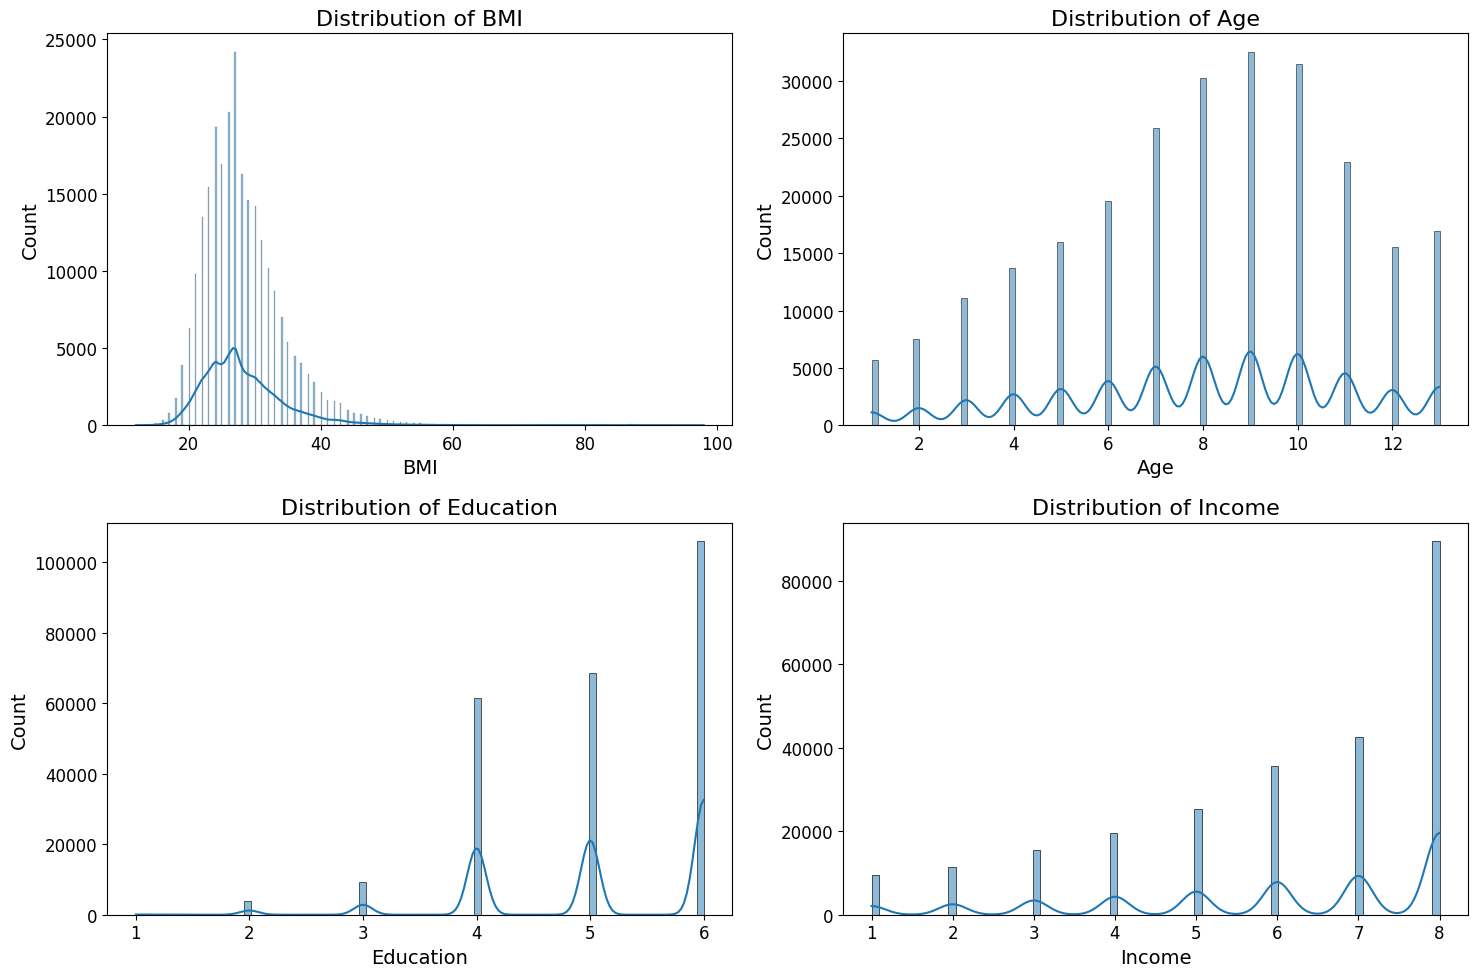

In [8]:
# Map 'MentHlth' and 'PhysHlth' to binary features
df['MentHlth'] = df['MentHlth'].map(lambda x: 1 if 0 <= x <= 5 else 2)
df['PhysHlth'] = df['PhysHlth'].map(lambda x: 1 if 0 <= x <= 5 else 2)

plt.rcParams.update({'font.size': 14})

numerical_features = ['BMI', 'Age', 'Education', 'Income']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], ax=axes[i//2, i%2], kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {feature}', fontsize=16)
    axes[i//2, i%2].tick_params(axis='both', which='major', labelsize=12)
    axes[i//2, i%2].set_xlabel(feature, fontsize=14)
    axes[i//2, i%2].set_ylabel('Count', fontsize=14)
    print(f"\nDistribution of {feature}:")
    print(df[feature].value_counts(normalize=True))

plt.tight_layout()
plt.show()

#### Distribution of Binary Features:


Distribution of MentHlth:
MentHlth
1    0.858369
2    0.141631
Name: proportion, dtype: float64

Distribution of PhysHlth:
PhysHlth
1    0.817233
2    0.182767
Name: proportion, dtype: float64

Distribution of HighBP:
HighBP
0.0    0.574718
1.0    0.425282
Name: proportion, dtype: float64

Distribution of HighChol:
HighChol
0.0    0.579537
1.0    0.420463
Name: proportion, dtype: float64

Distribution of CholCheck:
CholCheck
1.0    0.962224
0.0    0.037776
Name: proportion, dtype: float64

Distribution of Smoker:
Smoker
0.0    0.557754
1.0    0.442246
Name: proportion, dtype: float64

Distribution of Stroke:
Stroke
0.0    0.959739
1.0    0.040261
Name: proportion, dtype: float64

Distribution of HeartDiseaseorAttack:
HeartDiseaseorAttack
0.0    0.906729
1.0    0.093271
Name: proportion, dtype: float64

Distribution of PhysActivity:
PhysActivity
1.0    0.757995
0.0    0.242005
Name: proportion, dtype: float64

Distribution of Fruits:
Fruits
1.0    0.634851
0.0    0.365149
Name: proport

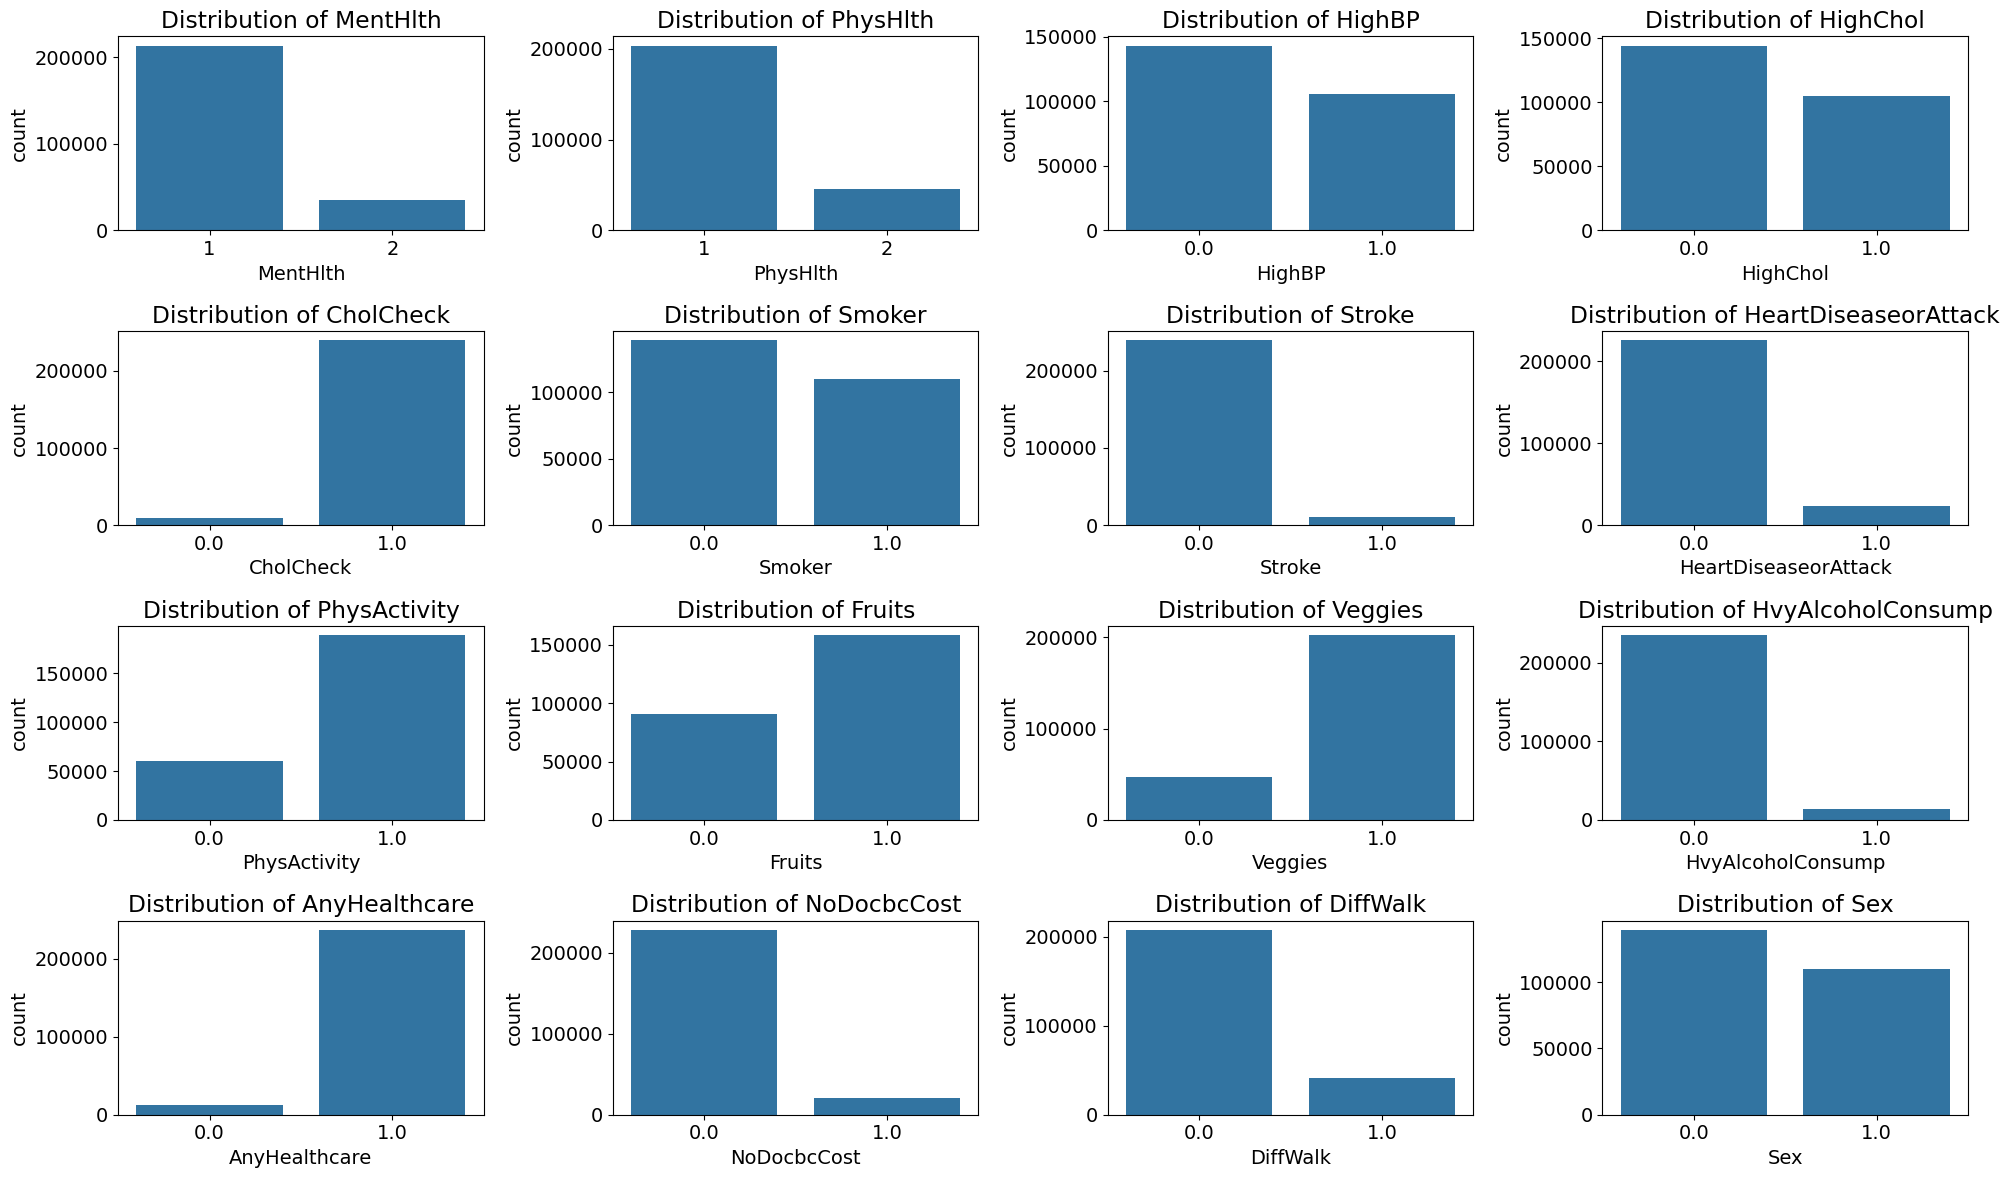

In [9]:
# Visualization for binary features
binary_features = ['MentHlth', 'PhysHlth', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                   'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
                   'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
fig, axes = plt.subplots(4, 4, figsize=(20, 12))
for i, feature in enumerate(binary_features):
    sns.countplot(x=feature, data=df, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Distribution of {feature}')
    print(f"\nDistribution of {feature}:")
    print(df[feature].value_counts(normalize=True))
plt.tight_layout()
plt.show()

#### Continuous Variables:

##### BMI:

Median: 27.0

Right-skewed distribution with potential outliers at the upper end

Most common BMI values are between 24.0 and 28.0

##### Age:

13-level age category (1 = 18-24, 13 = 80 or older)

Most common categories are 9.0 (60-64, 13.07%), 10.0 (65-69, 12.65%), and 8.0 (55-59, 12.16%)

Suggests a population skewed towards older age groups

##### Education:

Scale 1-6 (1 = Never attended school or only kindergarten, 6 = highest education level)

Most common level is 6 (42.50%), followed by 5 (27.54%) and 4 (24.65%)

Indicates a population with higher education levels on average

##### Income:

Scale 1-8 (1 = less than $10,000, 8 = $75,000 or more)

Most common category is 8 (35.89%), followed by 7 (17.06%) and 6 (14.34%)

Suggests a population skewed towards higher income levels

#### Binary Variables:

##### Mental and Physical Health:

MentHlth: 85.84% reported relatively good mental health (0-5 days), 14.16% reported poor mental health (6-30 days)

PhysHlth: 81.72% reported relatively good physical health (0-5 days), 18.28% reported poor physical health (6-30 days)

##### Notably imbalanced features:

CholCheck: 96.22% had cholesterol check in 5 years

AnyHealthcare: 95.12% have health care coverage

Stroke: 95.97% no history of stroke

HvyAlcoholConsump: 94.36% do not have heavy alcohol consumption

NoDocbcCost: 91.67% did not avoid doctor visits due to cost

HeartDiseaseorAttack: 90.67% no history of heart disease or attack

DiffWalk: 83.38% no difficulty walking or climbing stairs

Veggies: 81.22% consume vegetables 1 or more times per day

PhysActivity: 75.80% engaged in physical activity in the past 30 days

##### More balanced features:

HighBP: 57.47% no high blood pressure, 42.53% have high blood pressure

HighChol: 57.95% no high cholesterol, 42.05% have high cholesterol

Smoker: 55.78% have not smoked 100+ cigarettes, 44.22% have smoked 100+ cigarettes

Sex: 55.96% female, 44.04% male

Fruits: 63.49% consume fruits 1 or more times per day, 36.51% do not

### B. Bivariate Analysis

#### Correlation Analysis:

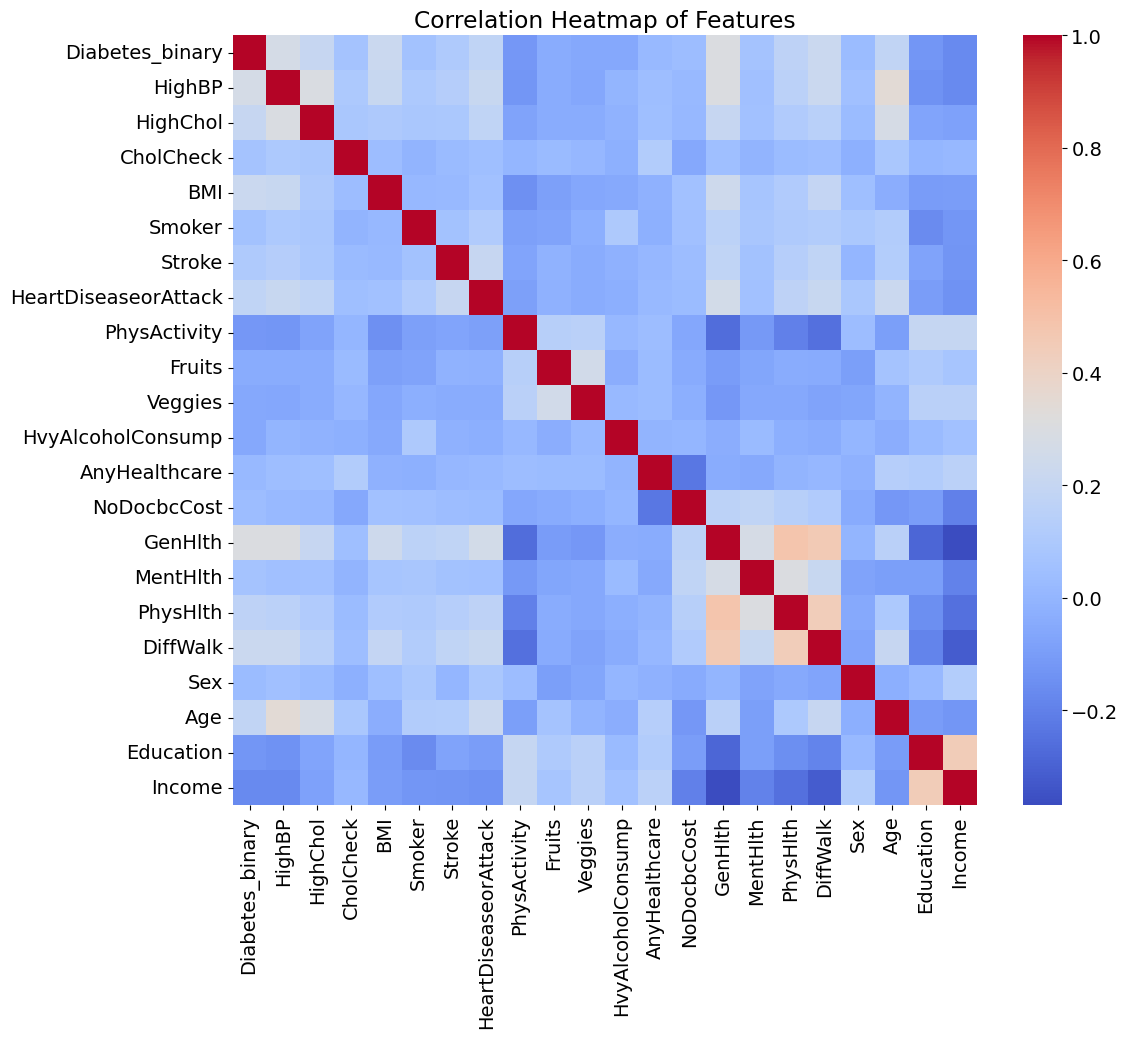

In [10]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

In [11]:
correlation_matrix

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,1.000000,0.269319,0.205684,0.066037,0.222353,0.062212,0.107990,0.181258,-0.121028,-0.041736,-0.058109,-0.057940,0.016241,0.033152,0.300347,0.065370,0.165647,0.223991,0.031728,0.181727,-0.128149,-0.168651
HighBP,0.269319,1.000000,0.297901,0.098365,0.213489,0.097235,0.130302,0.210217,-0.125304,-0.040398,-0.060786,-0.004026,0.038501,0.017169,0.300385,0.050711,0.155090,0.223973,0.052835,0.344943,-0.141102,-0.171155
HighChol,0.205684,0.297901,1.000000,0.085530,0.106792,0.090680,0.092650,0.181250,-0.077966,-0.040581,-0.039163,-0.011623,0.043103,0.012251,0.207539,0.053446,0.115807,0.144283,0.031689,0.272870,-0.069912,-0.084241
CholCheck,0.066037,0.098365,0.085530,1.000000,0.034090,-0.010065,0.024618,0.044574,0.004584,0.023957,0.005731,-0.023765,0.117995,-0.058594,0.046213,-0.006677,0.029998,0.040595,-0.022222,0.089745,0.002163,0.014737
BMI,0.222353,0.213489,0.106792,0.034090,1.000000,0.013554,0.020804,0.053592,-0.146581,-0.087227,-0.061432,-0.049026,-0.017712,0.057779,0.238740,0.079436,0.116203,0.196557,0.044163,-0.035915,-0.103388,-0.099561
Smoker,0.062212,0.097235,0.090680,-0.010065,0.013554,1.000000,0.060730,0.114122,-0.088291,-0.077226,-0.031043,0.101602,-0.023480,0.048942,0.163453,0.083628,0.108043,0.122109,0.093134,0.121421,-0.162795,-0.124594
Stroke,0.107990,0.130302,0.092650,0.024618,0.020804,0.060730,1.000000,0.203750,-0.069937,-0.013476,-0.041111,-0.016875,0.008975,0.034246,0.178329,0.061974,0.136330,0.177875,0.003135,0.127512,-0.076052,-0.128855
HeartDiseaseorAttack,0.181258,0.210217,0.181250,0.044574,0.053592,0.114122,0.203750,1.000000,-0.087733,-0.019757,-0.039660,-0.029641,0.018863,0.030581,0.259044,0.056629,0.169144,0.213143,0.085973,0.221933,-0.099750,-0.141089
PhysActivity,-0.121028,-0.125304,-0.077966,0.004584,-0.146581,-0.088291,-0.069937,-0.087733,1.000000,0.142747,0.153504,0.012665,0.035168,-0.061434,-0.266791,-0.113460,-0.199141,-0.253542,0.032573,-0.092890,0.200534,0.199237
Fruits,-0.041736,-0.040398,-0.040581,0.023957,-0.087227,-0.077226,-0.013476,-0.019757,0.142747,1.000000,0.254181,-0.035620,0.031136,-0.043610,-0.104101,-0.066734,-0.040377,-0.048020,-0.091887,0.064441,0.110232,0.079858


### C. Correlation Analysis

#### Strongest positive correlations with the target (Diabetes_binary):

GenHlth (0.300): General health has the strongest positive correlation with diabetes.

HighBP (0.269): High blood pressure is strongly associated with diabetes.

BMI (0.222): Higher BMI is correlated with increased diabetes risk.

DiffWalk (0.224): Difficulty walking shows a notable correlation with diabetes.

HighChol (0.206): High cholesterol is also positively correlated with diabetes.

#### Notable negative correlations with the target:

Income (-0.169): Higher income is associated with lower diabetes risk.

PhysActivity (-0.121): More physical activity is linked to lower diabetes risk.

Education (-0.128): Higher education levels are associated with lower diabetes risk.

### Feature Correlation Analysis:

#### Strong Positive Correlations:

GenHlth and PhysHlth (0.484): General health perception is strongly related to physical health.

GenHlth and DiffWalk (0.456): Difficulty walking is associated with poorer general health.

PhysHlth and DiffWalk (0.440): Physical health issues are related to difficulty walking.

Education and Income (0.448): Higher education levels are associated with higher income.

Age and HighBP (0.345): Blood pressure tends to increase with age.

#### Moderate Positive Correlations:

HighBP and HighChol (0.298): High blood pressure is often associated with high cholesterol.

GenHlth and MentHlth (0.278): General health perception is moderately related to mental health.

MentHlth and PhysHlth (0.300): Mental and physical health issues are correlated.

Age and HighChol (0.273): Cholesterol levels tend to increase with age.

#### Negative Correlations:

PhysActivity and GenHlth (-0.267): More physical activity is associated with better general health.

Income and GenHlth (-0.369): Higher income is associated with better general health.

Education and GenHlth (-0.284): Higher education is associated with better general health.

Income and DiffWalk (-0.320): Higher income is associated with less difficulty walking.

PhysActivity and DiffWalk (-0.254): More physical activity is associated with less difficulty walking.

### D. Data Preprocessing

In [12]:
# Identify continuous features
continuous_features = ['BMI']

# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Scale continuous features
df[continuous_features] = robust_scaler.fit_transform(df[continuous_features])

print("\nContinuous features scaled using RobustScaler:")
print(df[continuous_features].describe())

# Save the RobustScaler
joblib.dump(robust_scaler, 'robust_scaler.joblib')
print("RobustScaler saved as 'robust_scaler.joblib'")

# Handle binary features
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'MentHlth', 'PhysHlth', 
                   'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                   'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

for feature in binary_features:
    df[feature] = df[feature].astype(int)


Continuous features scaled using RobustScaler:
                 BMI
count  249049.000000
mean        0.191259
std         0.942004
min        -2.142857
25%        -0.428571
50%         0.000000
75%         0.571429
max        10.142857
RobustScaler saved as 'robust_scaler.joblib'


##### We have completed the following preprocessing steps:

Converted ordinal features to categorical data types, which allows the model to capture non-linear relationships.

Standardized continuous features, bringing them to the same scale and potentially improving model performance. By using RobustScaler, we are ensuring that our continuous features are scaled in a way that is less sensitive to outliers.

Ensured binary features are consistently encoded as 0 and 1.

These preprocessing steps have prepared our data for the subsequent stages of our analysis, including feature selection and model training. The standardized continuous features will work well with distance-based algorithms and neural networks, while the properly encoded categorical and binary features will allow our models to accurately capture the relationships in the data.






#### Given the nature of our diabetes prediction problem (binary classification with a mix of numerical and categorical features), I propose we try the following algorithms:

##### Logistic Regression

Rationale:

Simple and interpretable baseline model

Works well with linear relationships

Can handle both binary and continuous features

Provides feature coefficients that can be interpreted as log-odds, giving insights into feature importance

Computationally efficient, especially for large datasets

##### Random Forest Classifier

Rationale:

Handles non-linear relationships well

Can capture complex interactions between features

Robust to outliers and noise in the data

Provides feature importance scores

Generally performs well out-of-the-box with minimal tuning

Less prone to overfitting due to ensemble nature


##### Support Vector Machine (SVM) with RBF kernel

Rationale:

Effective in high-dimensional spaces

Versatile through different kernel functions

Works well when there's a clear margin of separation

Robust against overfitting in high dimensional spaces

Effective when number of samples is less than the number of dimensions

##### Neural Network (Multi-layer Perceptron)

Rationale:

Can capture complex non-linear relationships
Flexible architecture can be adapted to the problem
Can handle mixed data types well when properly encoded
Potential for high performance with proper tuning
Can learn hierarchical features

##### K-Nearest Neighbors (KNN)

Rationale:

Non-parametric method, makes no assumptions about data distribution
Simple and intuitive
Can capture local patterns in the data
Works well when decision boundary is very irregular
Provides a different perspective compared to other algorithms

##### Decision Tree

Rationale:

Works well with mixed data types

Good interpretability

Can handle high-dimensional data well

##### These algorithms cover a range of different approaches:

Linear (Logistic Regression) vs Non-linear (Random Forest, Decision Tree, Neural Network, KNN)

Parametric (Logistic Regression, Neural Network) vs Non-parametric (Random Forest, Decision Tree, KNN)

Distance-based (KNN, SVM) vs Tree-based (Random Forest, Decision Tree) vs Probabilistic (Logistic Regression)

Simple, interpretable models (Logistic Regression, KNN, Decision Tree) vs Complex, potentially more powerful models (Random Forest, SVM, Neural Network)

##### By comparing these diverse algorithms, we can:

Assess whether our diabetes prediction problem is better suited to linear or non-linear approaches.

Evaluate the trade-off between model complexity and performance, comparing simpler models like Logistic Regression and Naive Bayes against more complex ones like Neural Networks and SVMs.

Understand different aspects of our data through the strengths of each algorithm (e.g., feature interactions in Random Forest, local patterns in KNN).

Create a strong interpretable baseline (Logistic Regression) to compare against more complex, potentially black-box models.

Explore how different learning paradigms (e.g., distance-based, tree-based, probabilistic) perform on our specific dataset.

Identify which algorithms are most robust to the characteristics of our data.

This diverse set of algorithms will provide a comprehensive view of how different machine learning approaches perform on our diabetes prediction task, helping us identify the most effective model while also gaining insights into the nature of our data and the prediction problem itself.

In [13]:
def calculate_metrics(y_true, y_pred, y_pred_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'specificity': tn / (tn + fp),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'pr_auc': average_precision_score(y_true, y_pred_proba)
    }

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    return plt

def plot_pr_curve(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    return plt

def run_experiment(model_class, config, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)
    
    model = model_class(**config)
    
    # Log the config
    wandb.config.update(config)
    
    fold_metrics = []
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        model.fit(X_train_resampled, y_train_resampled)
        
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        metrics = calculate_metrics(y_val, y_pred, y_pred_proba)
        fold_metrics.append(metrics)
        
        wandb.log({f"Fold {fold} {k}": v for k, v in metrics.items()})
    
    mean_metrics = {f"Mean {k}": np.mean([m[k] for m in fold_metrics]) for k in fold_metrics[0].keys()}
    wandb.log(mean_metrics)
    
    # Train on full dataset for feature importance and final evaluation
    X_resampled, y_resampled = smote.fit_resample(X, y)
    model.fit(X_resampled, y_resampled)
    
    if hasattr(model, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(model.coef_[0])
        }).sort_values('importance', ascending=False)
    elif hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        feature_importance = None
    
    if feature_importance is not None:
        wandb.log({"Feature Importances": wandb.Table(dataframe=feature_importance)})
    
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    wandb.sklearn.plot_confusion_matrix(y, y_pred, labels=["No Diabetes", "Diabetes"])
    
    roc_plt = plot_roc_curve(y, y_pred_proba)
    wandb.log({"ROC Curve": wandb.Image(roc_plt)})
    plt.close()
    
    pr_plt = plot_pr_curve(y, y_pred_proba)
    wandb.log({"PR Curve": wandb.Image(pr_plt)})
    plt.close()
    
    return mean_metrics['Mean roc_auc']

def objective(model_class, experiment_name, sweep_id):
    with wandb.init(name=experiment_name, group=sweep_id, reinit=True) as run:
        config = wandb.config
        
        # Assuming df is defined in the global scope
        X = df.drop('Diabetes_binary', axis=1)
        y = df['Diabetes_binary']
        
        mean_roc_auc = run_experiment(model_class, config, X, y)
        
        # Log the objective metric
        wandb.log({"objective": mean_roc_auc})
        
        return mean_roc_auc

def run_sweep(model_class, sweep_config, project_name, experiment_name, count=30):
    sweep_id = wandb.sweep(sweep_config, project=project_name)
    
    wandb.agent(sweep_id, lambda: objective(model_class, experiment_name, sweep_id), count=count)
    
    return sweep_id

def create_summary_plot(sweep_id, project_name, sweep_config, experiment_name):
    api = wandb.Api()
    sweep = api.sweep(f"{project_name}/{sweep_id}")
    
    runs = sweep.runs
    
    data = []
    for run in runs:
        if run.state == "finished":
            data.append([run.config.get(key, None) for key in sweep_config['parameters'].keys()] + [run.summary.get("objective", None)])
    
    columns = list(sweep_config['parameters'].keys()) + ["objective"]
    summary_data = wandb.Table(data=data, columns=columns)
    
    scatter_plot = scatter(summary_data, x="parameter1", y="objective", title="Sweep Results")

    with wandb.init(project=project_name, name=f"{experiment_name}_summary", job_type="visualize") as run:
        wandb.log({"sweep_summary": scatter_plot})

### Hyperparameter tuning with Weights and Biases platform

In [14]:
project_name = "diabetes-prediction"
experiment_name = "logistic-regression-sweep"

lr_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {'min': 0.001, 'max': 10.0},
        'max_iter': {'min': 100, 'max': 1000}
    }
}

model_class = LogisticRegression
    
sweep_id = run_sweep(model_class, lr_sweep_config, project_name, experiment_name)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, lr_sweep_config, experiment_name)

Create sweep with ID: 6w2fglmo
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/6w2fglmo


/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

In [15]:
project_name = "diabetes-prediction"
experiment_name = "random-forest-sweep"

rf_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {'min': 10, 'max': 300},
        'max_depth': {'min': 3, 'max': 15},
        'min_samples_split': {'min': 2, 'max': 20},
        'min_samples_leaf': {'min': 1, 'max': 10},
        'max_features': {'values': ['sqrt', 'log2', None]}
    }
}

model_class = RandomForestClassifier

# Run the sweep
sweep_id = run_sweep(model_class, rf_sweep_config, project_name, experiment_name, count=30)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, rf_sweep_config, experiment_name)

Create sweep with ID: s52ahol0
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/s52ahol0


In [18]:
project_name = "diabetes-prediction"
experiment_name = "svm-sweep"

svm_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {'min': 0.1, 'max': 10.0},
        'kernel': {'values': ['rbf', 'linear', 'poly', 'sigmoid']},
        'gamma': {'values': ['scale', 'auto']},
        'class_weight': {'values': [None, 'balanced']},
        'probability': {'values': [True]},  # We need this for AUC calculation
        'random_state': {'value': 42}
    }
}

model_class = SVC

# Run the sweep
sweep_id = run_sweep(model_class, svm_sweep_config, project_name, experiment_name, count=30)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, svm_sweep_config, experiment_name)

Create sweep with ID: p98rksfr
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/p98rksfr


wandb: Network error (ConnectionError), entering retry loop.


In [15]:
project_name = "diabetes-prediction"
experiment_name = "knn-sweep"

knn_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'n_neighbors': {'min': 1, 'max': 50},
        'metric': {'values': ['euclidean']}
    }
}

model_class = KNeighborsClassifier

# Run the sweep
sweep_id = run_sweep(model_class, knn_sweep_config, project_name, experiment_name, count=30)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, knn_sweep_config, experiment_name)

Create sweep with ID: uo17l3m0
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/uo17l3m0


In [20]:
project_name = "diabetes-prediction"
experiment_name = "naive-bayes-sweep"

nb_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'var_smoothing': {'min': 1e-10, 'max': 1e-8, 'distribution': 'log_uniform'}
    }
}

model_class = GaussianNB

# Run the sweep
sweep_id = run_sweep(model_class, nb_sweep_config, project_name, experiment_name, count=30)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, nb_sweep_config, experiment_name)

Create sweep with ID: grgasrws
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/grgasrws


In [22]:
project_name = "diabetes-prediction"
experiment_name = "mlp-sweep"

mlp_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'hidden_layer_sizes': {
            'values': [(50,), (100,), (50, 50), (100, 50), (100, 100)]
        },
        'activation': {
            'values': ['relu', 'tanh', 'logistic']
        },
        'solver': {
            'values': ['adam', 'sgd']
        },
        'alpha': {
            'distribution': 'log_uniform',
            'min': 1e-5,
            'max': 1e-2
        },
        'learning_rate': {
            'values': ['constant', 'adaptive', 'invscaling']
        },
        'max_iter': {
            'values': [200, 500, 1000]
        },
        'early_stopping': {
            'values': [True, False]
        },
        'n_iter_no_change': {
            'values': [10, 20, 50]
        }
    }
}

model_class = MLPClassifier

# Run the sweep
sweep_id = run_sweep(model_class, mlp_sweep_config, project_name, experiment_name, count=30)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, mlp_sweep_config, experiment_name)

Create sweep with ID: 6a15ixth
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/6a15ixth


/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawadur/Desktop/uwe/machine-learning/diabetes-prediction/myenv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_pe

In [14]:
project_name = "diabetes-prediction"
experiment_name = "decision-tree-sweep"

dt_sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Mean AUC',
        'goal': 'maximize'
    },
    'parameters': {
        'criterion': {
            'values': ['gini', 'entropy']
        },
        'max_depth': {
            'min': 3,
            'max': 20
        },
        'min_samples_split': {
            'min': 2,
            'max': 20
        },
        'min_samples_leaf': {
            'min': 1,
            'max': 10
        },
        'max_features': {
            'values': ['sqrt', 'log2', None]
        },
        'class_weight': {
            'values': [None, 'balanced']
        },
        'random_state': {
            'values': [42]
        }
    }
}

model_class = DecisionTreeClassifier

# Run the sweep
sweep_id = run_sweep(model_class, dt_sweep_config, project_name, experiment_name, count=30)

# Create summary plot after the sweep is complete
create_summary_plot(sweep_id, project_name, dt_sweep_config, experiment_name)

Create sweep with ID: m9jhcbop
Sweep URL: https://wandb.ai/jawadur/diabetes-prediction/sweeps/m9jhcbop


### Tuned hyperparameters of best model (Random Forest)

max_depth 12

max_features sqrt

min_samples_leaf 9

min_samples_split 2

n_estimators 116

In [15]:
def run_model(model_class, config, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)
    
    model = model_class(**config)
    
    fold_metrics = []
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        model.fit(X_train_resampled, y_train_resampled)
        
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        metrics = calculate_metrics(y_val, y_pred, y_pred_proba)
        fold_metrics.append(metrics)
        
        print(f"Fold {fold} metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v}")
        print()
    
    mean_metrics = {f"Mean {k}": np.mean([m[k] for m in fold_metrics]) for k in fold_metrics[0].keys()}
    print("Mean metrics:")
    for k, v in mean_metrics.items():
        print(f"{k}: {v}")
    print()
    
    # Train on full dataset for feature importance and final evaluation
    X_resampled, y_resampled = smote.fit_resample(X, y)
    model.fit(X_resampled, y_resampled)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Feature Importances:")
    print(feature_importance)
    print()
    
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    roc_plt = plot_roc_curve(y, y_pred_proba)
    roc_plt.savefig('roc_curve.png')
    plt.close()
    
    pr_plt = plot_pr_curve(y, y_pred_proba)
    pr_plt.savefig('pr_curve.png')
    plt.close()
    
    return model, mean_metrics['Mean roc_auc']

In [16]:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

# Best hyperparameters
best_config = {
    'max_depth': 12,
    'max_features': 'sqrt',
    'min_samples_leaf': 9,
    'min_samples_split': 2,
    'n_estimators': 116,
    'random_state': 42  # for reproducibility
}

# Train the model
best_model, mean_roc_auc = run_model(RandomForestClassifier, best_config, X, y)

print(f"Best model Mean ROC AUC: {mean_roc_auc}")

# Save the model
joblib.dump(best_model, 'best_rf_model.joblib')

Fold 1 metrics:
accuracy: 0.7621160409556313
precision: 0.3391655450874832
recall: 0.7129721318432592
f1_score: 0.4596652834146564
specificity: 0.7702440279824992
roc_auc: 0.82579463212756
pr_auc: 0.42684798537302593

Fold 2 metrics:
accuracy: 0.7579200963661915
precision: 0.3345493135239106
recall: 0.7135379827415476
f1_score: 0.4555224419759776
specificity: 0.7652605226831379
roc_auc: 0.8224209243774352
pr_auc: 0.41607395673008707

Fold 3 metrics:
accuracy: 0.759887572776551
precision: 0.337216268388471
recall: 0.7166501626821332
f1_score: 0.45862755748687306
specificity: 0.7670386748087317
roc_auc: 0.8260619238952387
pr_auc: 0.42436560227791564

Fold 4 metrics:
accuracy: 0.7603894800240916
precision: 0.3363825923185579
recall: 0.7073550212164074
f1_score: 0.45594201577243926
specificity: 0.769162377164249
roc_auc: 0.8229540529592769
pr_auc: 0.4256736199124629

Fold 5 metrics:
accuracy: 0.7599429821919733
precision: 0.3375
recall: 0.718064789927854
f1_score: 0.45917951965263015
speci

['best_rf_model.joblib']

In [17]:
# Load the best model
best_model = joblib.load('best_rf_model.joblib')

In [18]:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [19]:
# Get feature names
feature_names = X.columns.tolist()

### SHAP Analysis

See report/paper for details

Calculating SHAP values


 98%|===================| 975/1000 [00:27<00:00]        

Shape of X_sample: (500, 21)
Shape of shap_values: (500, 21, 2)
Shape of shap_values_plot: (500, 21)
Plotting summary plot


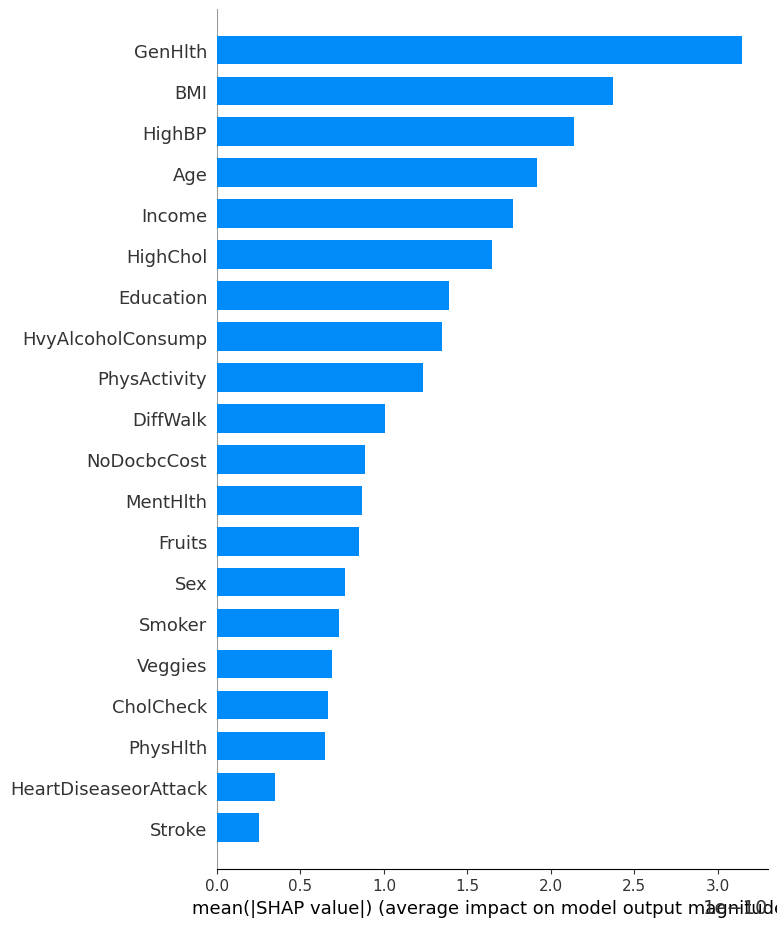

<Figure size 640x480 with 0 Axes>

Plotting detailed summary plot


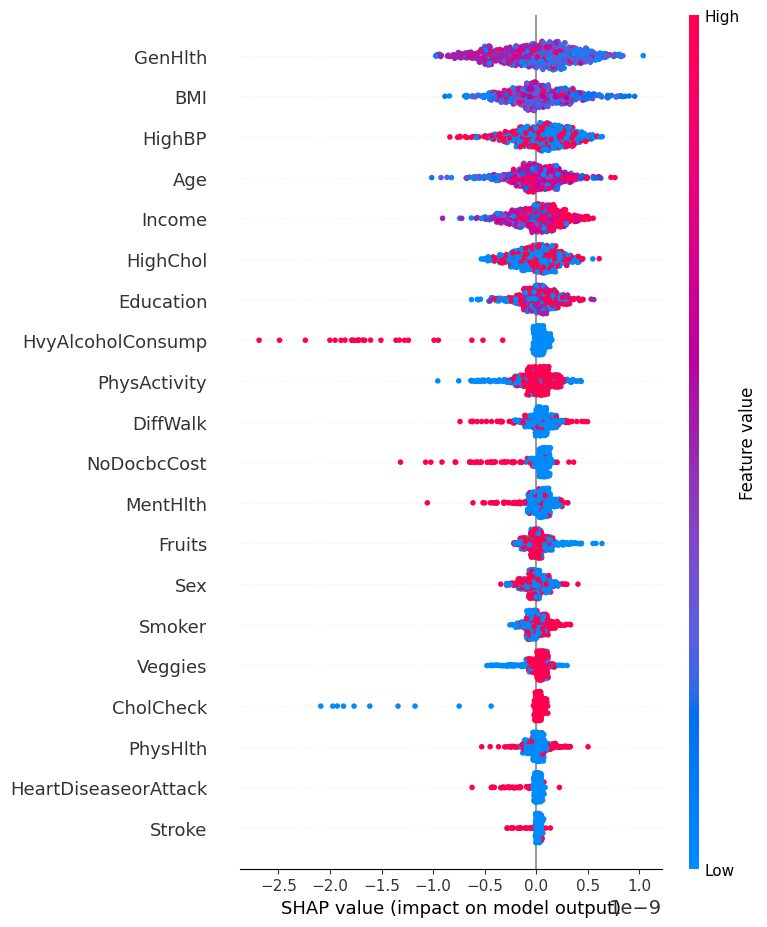

<Figure size 640x480 with 0 Axes>

Plotting force plot


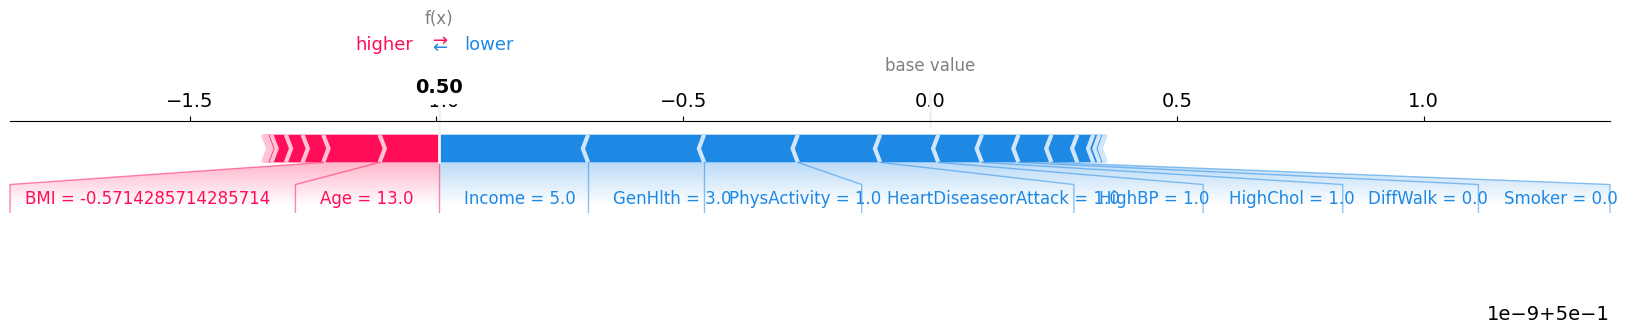

Plotting dependence plots


<Figure size 1000x600 with 0 Axes>

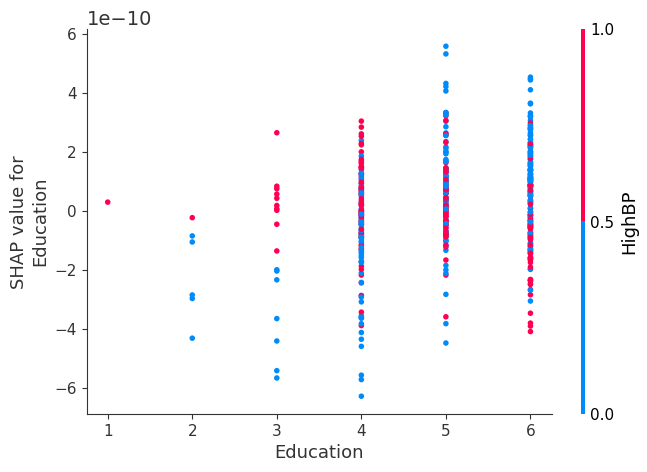

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

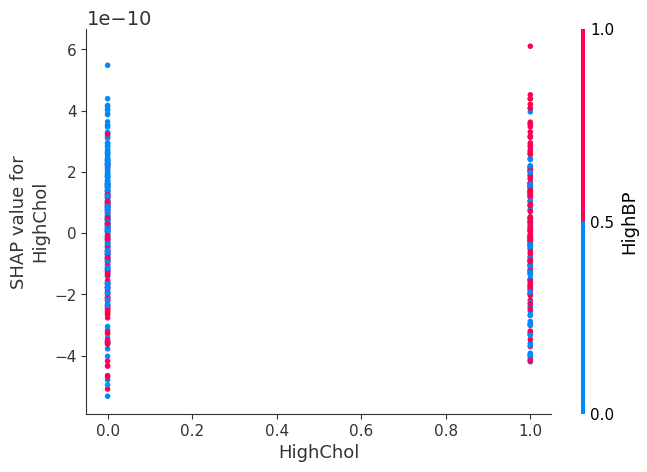

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

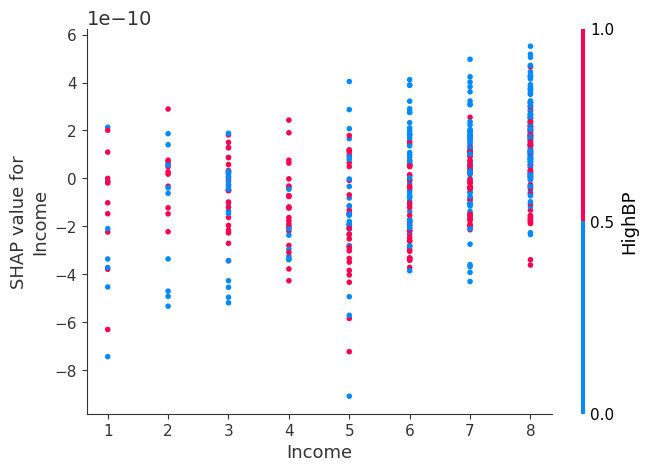

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

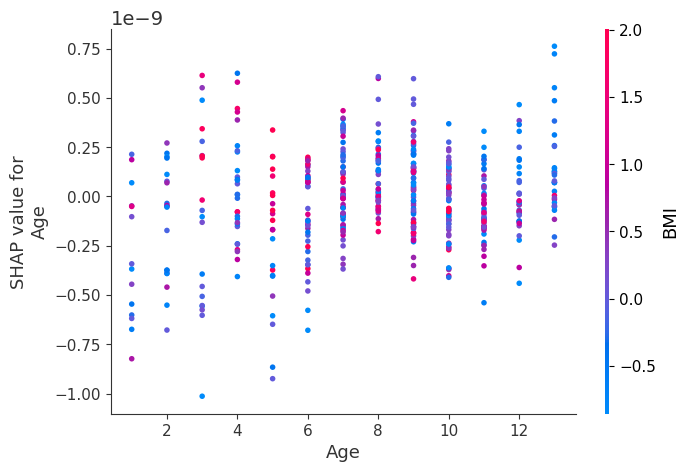

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

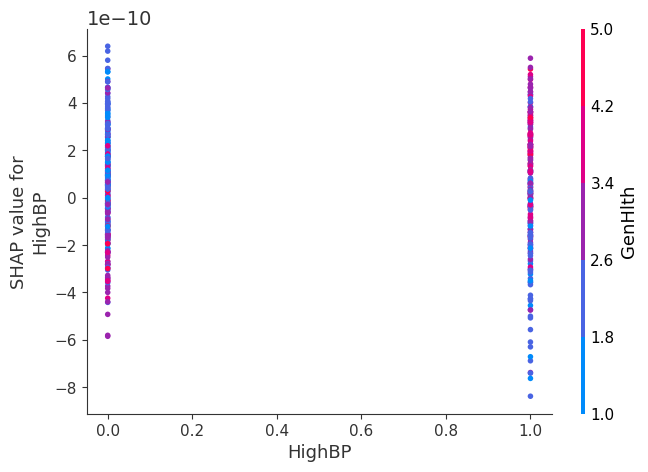

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

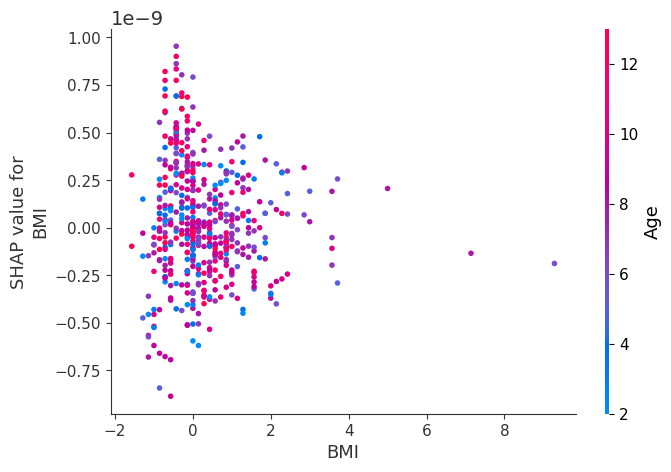

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

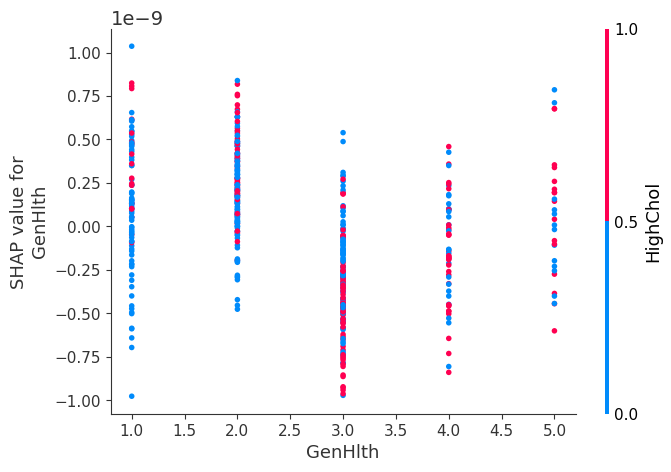

<Figure size 640x480 with 0 Axes>

Feature names:
0: HighBP
1: HighChol
2: CholCheck
3: BMI
4: Smoker
5: Stroke
6: HeartDiseaseorAttack
7: PhysActivity
8: Fruits
9: Veggies
10: HvyAlcoholConsump
11: AnyHealthcare
12: NoDocbcCost
13: GenHlth
14: MentHlth
15: PhysHlth
16: DiffWalk
17: Sex
18: Age
19: Education
20: Income

Top 10 features by SHAP importance:
              feature  shap_importance
13            GenHlth     3.144113e-10
3                 BMI     2.369696e-10
0              HighBP     2.137660e-10
18                Age     1.919172e-10
20             Income     1.774671e-10
1            HighChol     1.645785e-10
19          Education     1.391732e-10
10  HvyAlcoholConsump     1.350327e-10
7        PhysActivity     1.233486e-10
16           DiffWalk     1.004686e-10


In [20]:
# Load the best model
best_model = joblib.load('best_rf_model.joblib')

X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

# Get feature names
feature_names = X.columns.tolist()

def perform_shap_analysis(model, X, feature_names, sample_size=500):
    # Sample the data
    X_sample = X.sample(n=sample_size, random_state=42)
    
    # Create a SHAP explainer
    explainer = shap.TreeExplainer(model, feature_perturbation="interventional", data=shap.sample(X, 500))

    print('Calculating SHAP values')
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample)
    
    print(f"Shape of X_sample: {X_sample.shape}")
    print(f"Shape of shap_values: {shap_values.shape}")

    # Take the mean of SHAP values across the third dimension
    shap_values_plot = np.mean(shap_values, axis=2)
    
    print(f"Shape of shap_values_plot: {shap_values_plot.shape}")

    print('Plotting summary plot')
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, X_sample, feature_names=feature_names, plot_type="bar")
    plt.tight_layout()
    plt.show()

    print('Plotting detailed summary plot')
    # Detailed summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, X_sample, feature_names=feature_names)
    plt.tight_layout()
    plt.show()

    print('Plotting force plot')
    # Force plot for a single prediction (let's use the first sample)
    shap.force_plot(explainer.expected_value.mean(), shap_values_plot[0], X_sample.iloc[0], 
                    feature_names=feature_names, matplotlib=True, show=False)
    plt.tight_layout()

    # Adjust the plot
    plt.subplots_adjust(top=0.8, left=0.1, right=0.9, bottom=0.2)  # Adjust these values as needed

    # Get the current axis
    ax = plt.gca()

    # Move the 'f(x)' label
    text_obj = ax.texts[-1]  # The 'f(x)' label is typically the last text object
    text_obj.set_position((text_obj.get_position()[0], 0.5))  # Move it up

    plt.show()

    print('Plotting dependence plots')
    # Dependence plots for top 7 features
    top_features = np.argsort(np.abs(shap_values_plot).mean(0))[-7:]
    for feature in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values_plot, X_sample, feature_names=feature_names)
        plt.tight_layout()
        plt.show()

    return shap_values_plot, X_sample

# Use the function
shap_values, X_sample = perform_shap_analysis(best_model, X, feature_names)

# Print feature names
print("Feature names:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

# Print top 10 features by mean absolute SHAP value
mean_shap = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names, mean_shap)), columns=['feature', 'shap_importance'])
feature_importance = feature_importance.sort_values('shap_importance', ascending=False)
print("\nTop 10 features by SHAP importance:")
print(feature_importance.head(10))

### Train simpler model with feature subset following SHAP Analysis

In [21]:
selected_feature_names = [
    'GenHlth',
    'BMI',
    'HighBP',
    'Age',
    'Income',
    'HighChol',
    'Education',
    'HvyAlcoholConsump',
    'PhysActivity',
    'DiffWalk'
]

In [22]:
X = df[selected_feature_names]
y = df['Diabetes_binary']

# Best hyperparameters
best_config = {
    'max_depth': 12,
    'max_features': 'sqrt',
    'min_samples_leaf': 9,
    'min_samples_split': 2,
    'n_estimators': 116,
    'random_state': 42  # for reproducibility
}

# Train the model
feature_selected_model, mean_roc_auc = run_model(RandomForestClassifier, best_config, X, y)

print(f"Best model Mean ROC AUC: {mean_roc_auc}")

Fold 1 metrics:
accuracy: 0.7605300140534029
precision: 0.33873216063723866
recall: 0.7218842834913001
f1_score: 0.46110056925996207
specificity: 0.7669216911162584
roc_auc: 0.8261946868988979
pr_auc: 0.43138555753373553

Fold 2 metrics:
accuracy: 0.7557518570568159
precision: 0.333115054678803
recall: 0.7196208798981468
f1_score: 0.45541629364368846
specificity: 0.7617276151704453
roc_auc: 0.822475128421335
pr_auc: 0.4248856666900709

Fold 3 metrics:
accuracy: 0.7560329251154386
precision: 0.3338563116951036
recall: 0.7224501343895884
f1_score: 0.45667531073951534
specificity: 0.7615872347394773
roc_auc: 0.8260684110373308
pr_auc: 0.43289212722990167

Fold 4 metrics:
accuracy: 0.7577394097570769
precision: 0.33397567944713935
recall: 0.7108910891089109
f1_score: 0.45445092454450925
specificity: 0.7654890032756201
roc_auc: 0.8216346313587171
pr_auc: 0.42995075306220554

Fold 5 metrics:
accuracy: 0.7578349294304242
precision: 0.3364345148398087
recall: 0.7264110906776065
f1_score: 0.459

In [23]:
# Save the model
joblib.dump(feature_selected_model, 'feature_selected_rf_model.joblib')

['feature_selected_rf_model.joblib']

### Perform SHAP Analysis again on selected features

Calculating SHAP values


 97%|=================== | 968/1000 [00:26<00:00]       

Shape of X_sample: (500, 10)
Shape of shap_values: (500, 10, 2)
Shape of shap_values_plot: (500, 10)
Plotting summary plot


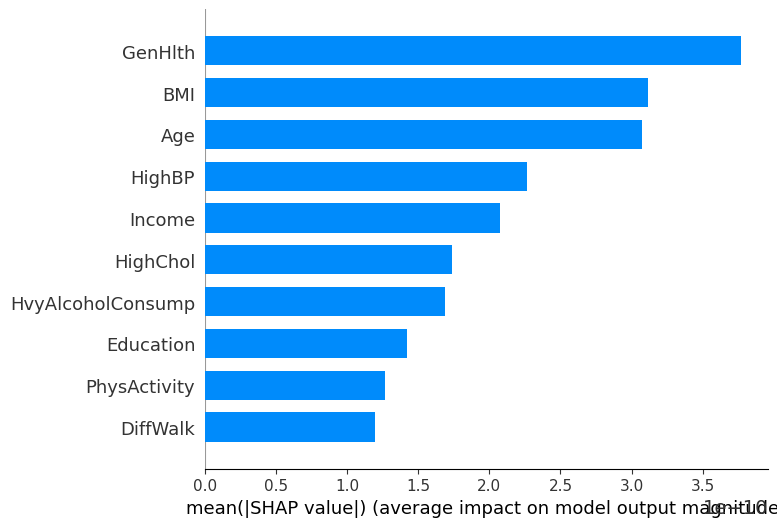

<Figure size 640x480 with 0 Axes>

Plotting detailed summary plot


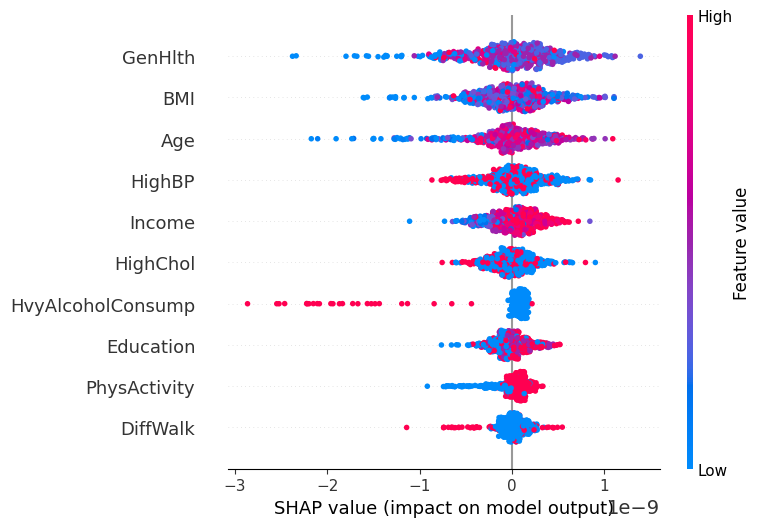

<Figure size 640x480 with 0 Axes>

Plotting force plot


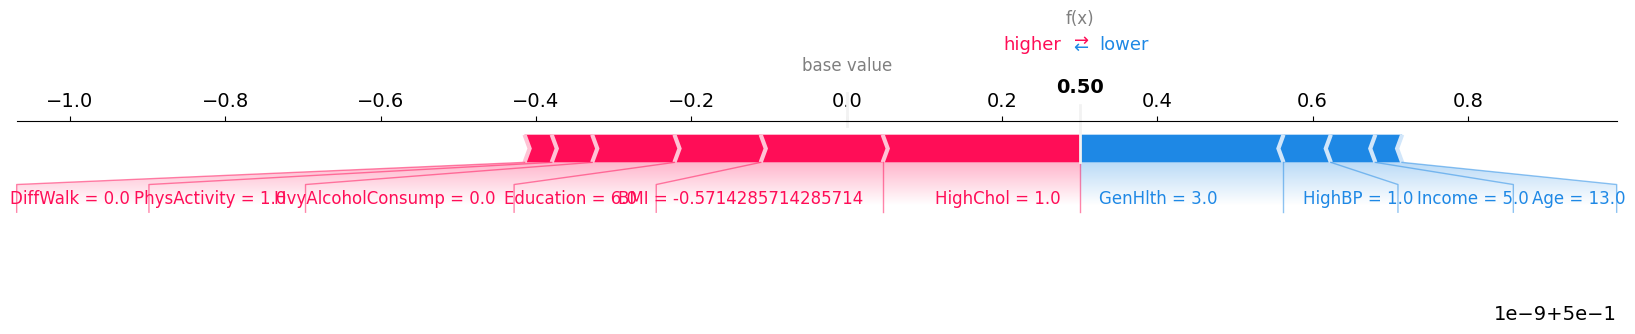

Plotting dependence plots


<Figure size 1000x600 with 0 Axes>

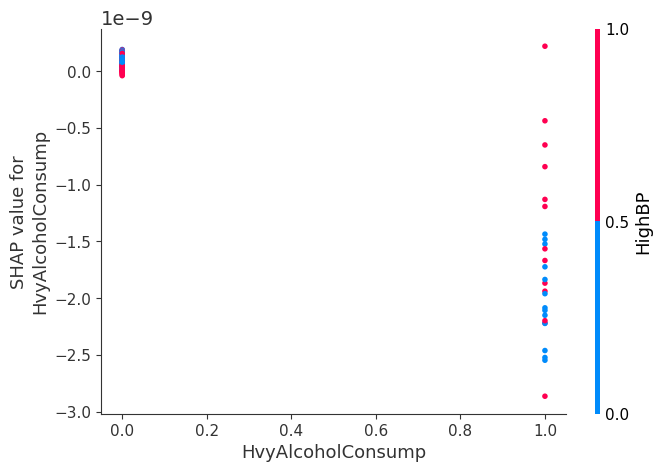

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

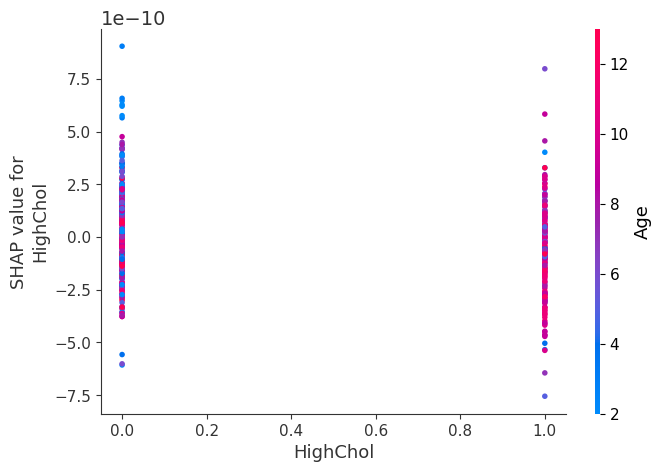

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

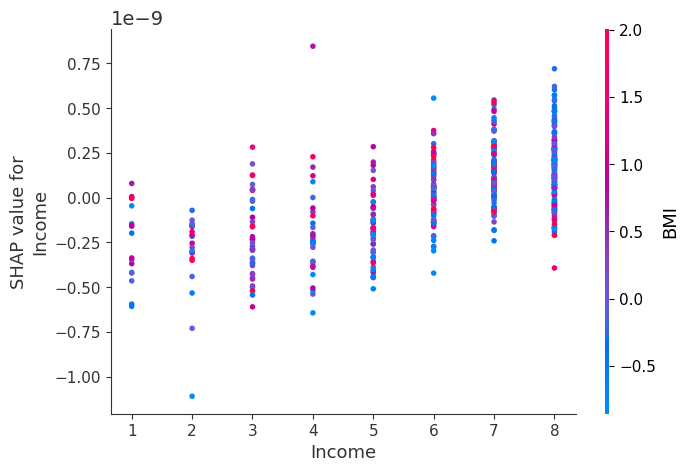

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

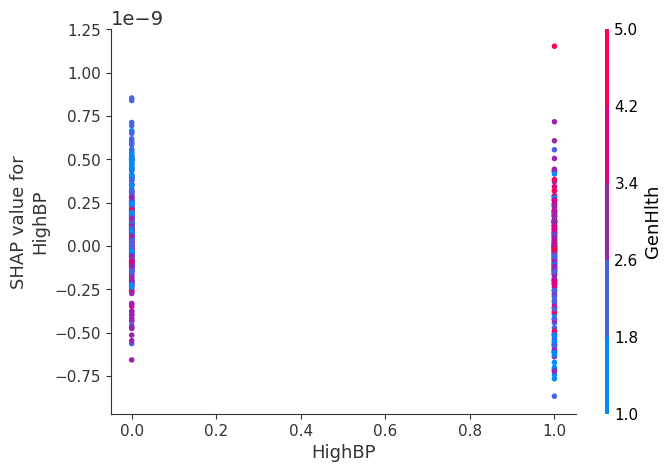

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

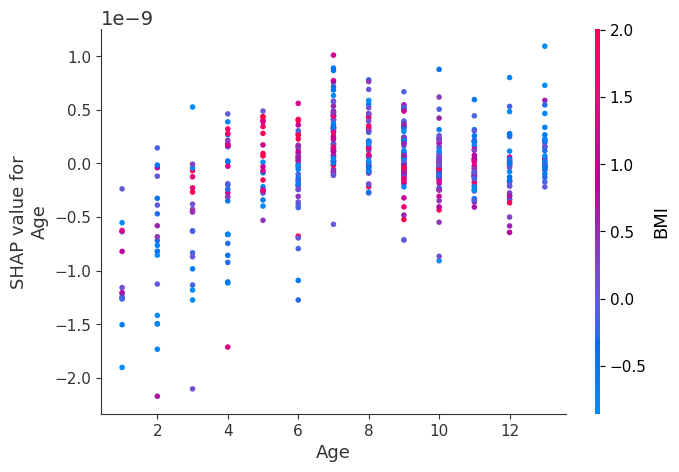

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

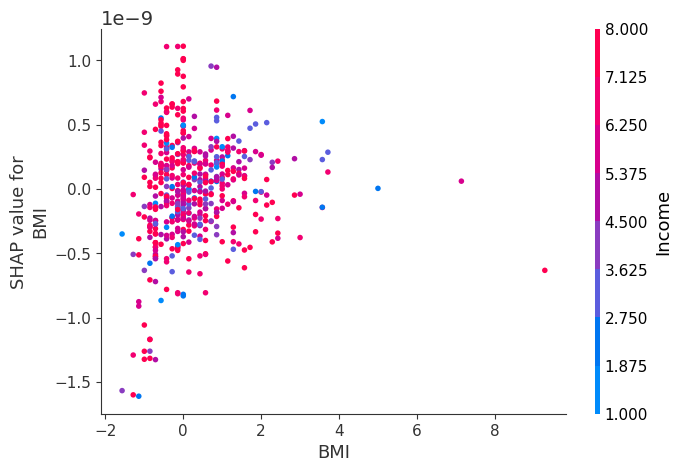

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

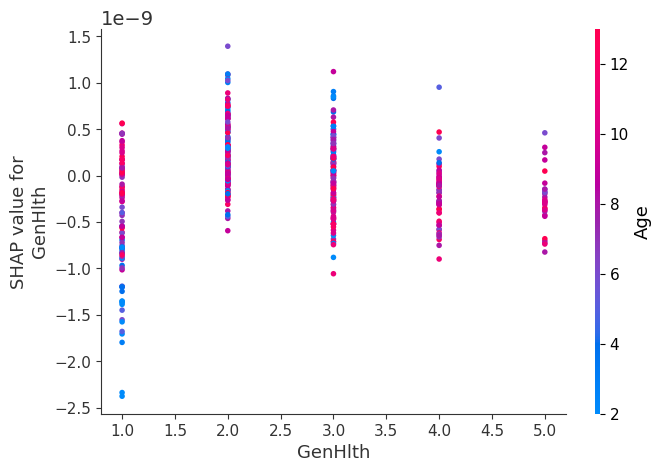

<Figure size 640x480 with 0 Axes>

Feature names:
0: GenHlth
1: BMI
2: HighBP
3: Age
4: Income
5: HighChol
6: Education
7: HvyAlcoholConsump
8: PhysActivity
9: DiffWalk

Top 10 features by SHAP importance:
             feature  shap_importance
0            GenHlth     3.770958e-10
1                BMI     3.113642e-10
3                Age     3.074158e-10
2             HighBP     2.266722e-10
4             Income     2.072725e-10
5           HighChol     1.738049e-10
7  HvyAlcoholConsump     1.687499e-10
6          Education     1.421502e-10
8       PhysActivity     1.267750e-10
9           DiffWalk     1.196903e-10


In [24]:
# Use the function
shap_values, X_sample = perform_shap_analysis(feature_selected_model, X, selected_feature_names)

# Print feature names
print("Feature names:")
for i, name in enumerate(selected_feature_names):
    print(f"{i}: {name}")

# Print top 10 features by mean absolute SHAP value
mean_shap = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(selected_feature_names, mean_shap)), columns=['feature', 'shap_importance'])
feature_importance = feature_importance.sort_values('shap_importance', ascending=False)
print("\nTop 10 features by SHAP importance:")
print(feature_importance.head(10))

### Sensitivity Analysis

See report/paper for details

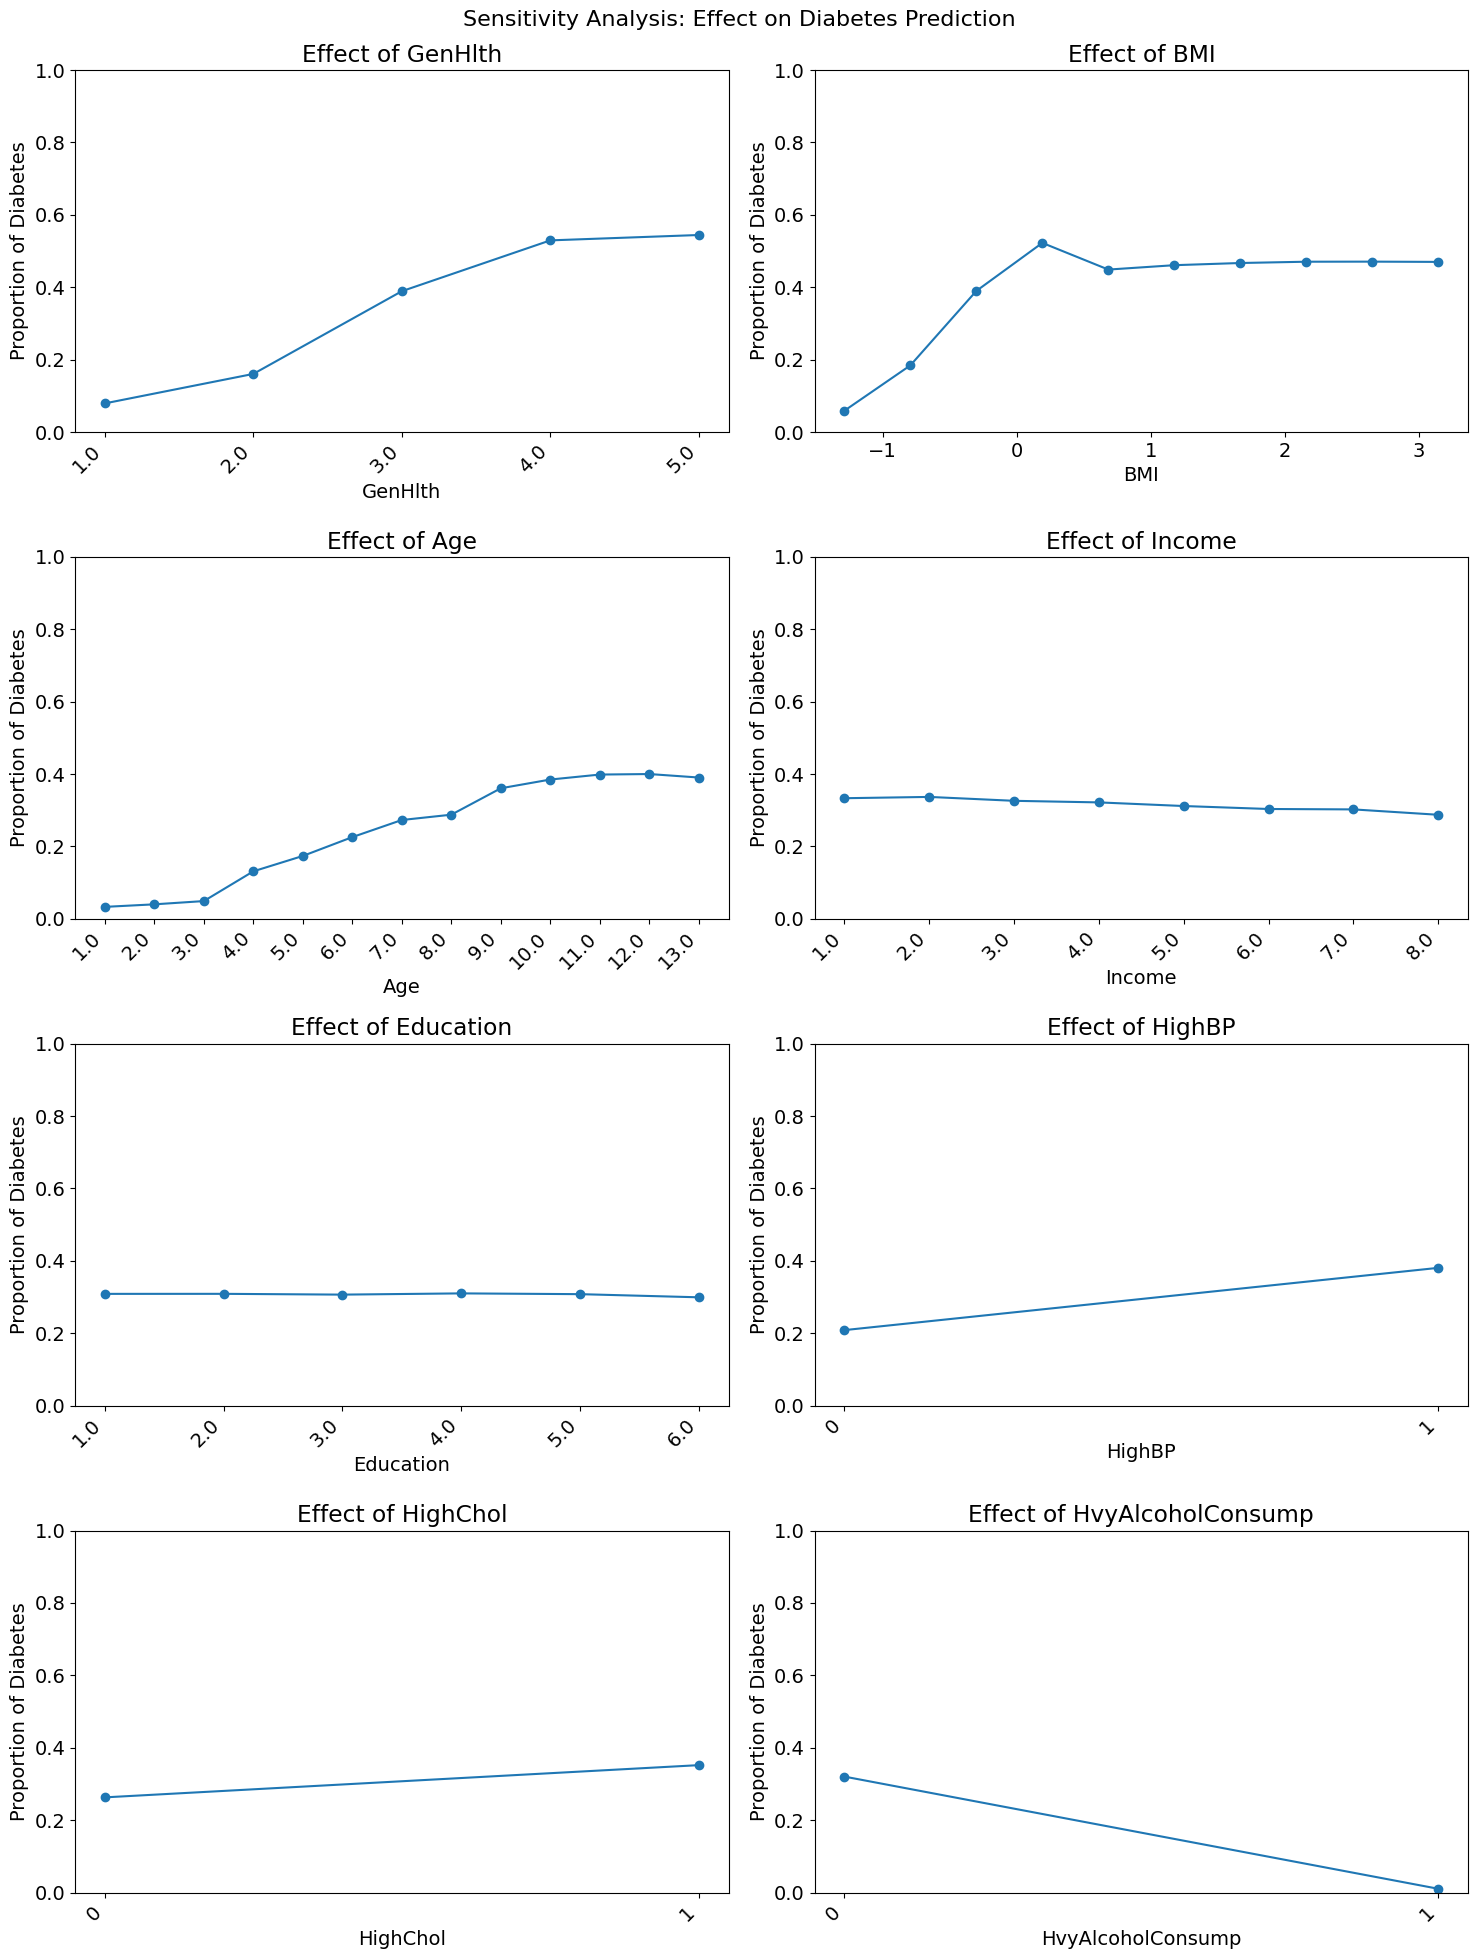

GenHlth:
  Minimum proportion: 0.0791 at value 1.00
  Maximum proportion: 0.5442 at value 5.00
  Range: 0.4651

BMI:
  Minimum proportion: 0.0587 at value -1.29
  Maximum proportion: 0.5224 at value 0.19
  Range: 0.4637

Age:
  Minimum proportion: 0.0331 at value 1.00
  Maximum proportion: 0.4000 at value 12.00
  Range: 0.3669

Income:
  Minimum proportion: 0.2875 at value 8.00
  Maximum proportion: 0.3368 at value 2.00
  Range: 0.0494

Education:
  Minimum proportion: 0.2994 at value 6.00
  Maximum proportion: 0.3102 at value 4.00
  Range: 0.0108

HighBP:
  Minimum proportion: 0.2088 at value 0.00
  Maximum proportion: 0.3808 at value 1.00
  Range: 0.1720

HighChol:
  Minimum proportion: 0.2629 at value 0.00
  Maximum proportion: 0.3519 at value 1.00
  Range: 0.0890

HvyAlcoholConsump:
  Minimum proportion: 0.0104 at value 1.00
  Maximum proportion: 0.3203 at value 0.00
  Range: 0.3099

Data used for plotting:

DataFrame for GenHlth:
   GenHlth  Proportion
0      1.0    0.079085
1    

In [25]:
def sensitivity_analysis(model, X, feature, values):
    results = []
    X_copy = X.copy()  # Create a copy of X
    
    for value in values:
        X_copy[feature] = value
        predictions = model.predict(X_copy)
        diabetes_proportion = predictions.mean()
        results.append((value, diabetes_proportion))
    
    return results

# List of features to analyze
features_to_analyze = ['GenHlth', 'BMI', 'Age', 'Income', 'Education', 'HighBP', 'HighChol', 'HvyAlcoholConsump']

# Perform sensitivity analysis
sensitivity_results = {}
sensitivity_dfs = {}
for feature in features_to_analyze:
    if feature == 'BMI':
        start, end = X[feature].quantile(0.01), X[feature].quantile(0.99)
        values = np.linspace(start, end, 10)
    else:
        values = sorted(X[feature].unique())
    
    X_subset = X[selected_feature_names]

    sensitivity_results[feature] = sensitivity_analysis(feature_selected_model, X_subset, feature, values)
    
    # Create a DataFrame for each feature
    df = pd.DataFrame(sensitivity_results[feature], columns=[feature, 'Proportion'])
    sensitivity_dfs[feature] = df

# Plotting the results
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Sensitivity Analysis: Effect on Diabetes Prediction', fontsize=16)

for i, feature in enumerate(features_to_analyze):
    row = i // 2
    col = i % 2
    values, proportions = zip(*sensitivity_results[feature])
    axs[row, col].plot(values, proportions, marker='o')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Proportion of Diabetes')
    axs[row, col].set_title(f'Effect of {feature}')
    
    if feature != 'BMI':
        axs[row, col].set_xticks(values)
        axs[row, col].set_xticklabels(values, rotation=45, ha='right')
    
    # Set y-axis limits to be the same for all subplots
    axs[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust to make room for the main title
plt.show()

# Print some key findings
for feature in features_to_analyze:
    min_prop = min(sensitivity_results[feature], key=lambda x: x[1])
    max_prop = max(sensitivity_results[feature], key=lambda x: x[1])
    print(f"{feature}:")
    print(f"  Minimum proportion: {min_prop[1]:.4f} at value {min_prop[0]:.2f}")
    print(f"  Maximum proportion: {max_prop[1]:.4f} at value {max_prop[0]:.2f}")
    print(f"  Range: {max_prop[1] - min_prop[1]:.4f}")
    print()

# Print the DataFrames used for plotting
print("Data used for plotting:")
for feature, df in sensitivity_dfs.items():
    print(f"\nDataFrame for {feature}:")
    print(df)